# Проект для «Викишоп» - классификация текстов по эмоциям. 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.  

**План работы**

1. Загрузить и подготовить данные:
- почистить комментарии от стоп-слов, знаков пунктуации, провести лемматизацию.
2. Обучить разные модели:
- проверим работу LogisticRegression и LightGBM. 

**Цель проекта:**
- построить модель машинного обцчения, которая будет определять токсичные комментраии или нет.


## Подготовка

In [1]:
# импортируем библиотеки

import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()
import re

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')

from nltk.stem import WordNetLemmatizer 
WNL = WordNetLemmatizer()

from sklearn.feature_extraction.text import TfidfVectorizer 

from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from numpy.random import RandomState
STATE = RandomState(12345)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# загрузим данные

try:
    data = pd.read_csv('/datasets/toxic_comments.csv')
except:
    data_0 = pd.read_csv('toxic_comments.csv')

data

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0


In [3]:
# посмотрим на общие сведения

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


In [4]:
# проверим данные на наличие дубликатов

data.duplicated().sum()


0

- **Данные состоят из двух столбцов и почти 160 тыс. строк. Столбец text содержит комментарии, toxic - эмоциональную оценку.**
- **Дубликаты и пропуски отсутствуют.**

0    143346
1     16225
Name: toxic, dtype: int64



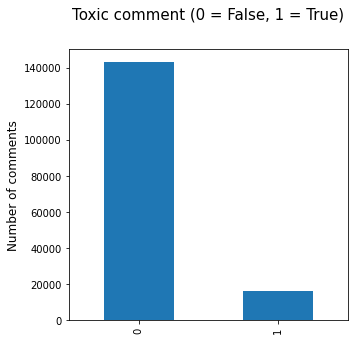

In [5]:
# посмотрим на соотношение классов на тренировочной выборке

xx = data['toxic'].value_counts()
print(xx)
print()
ax = data['toxic'].value_counts().plot(kind='bar', figsize=(5,5), fontsize=10)
ax.set_title('Toxic comment (0 = False, 1 = True)', size=15, pad=30)
ax.set_ylabel('Number of comments', fontsize=12)

plt.show()

- **Судя по графику виден явный дисбаланс классов.**

In [6]:
# напишем функции для того, чтобы привести столбец text в нужный вид

# почистим текст от лишних символов
def clear_text(text):
    text = re.sub(r'[^a-zA-Z0-9]+', ' ', text)
    text = text.split()
    text = " ".join(text)
    return text

# поделим текст на токены
def tokenized_text(text):
    text = re.split('\W+', text)
    return text

# удалим из текста стоп-слова
def delete_stopwords(text):
    text = [w for w in text if w not in STOPWORDS]
    return text

# лемматтизируем текст
def lemmatizer(text):
    text = [WNL.lemmatize(w) for w in text]
    return text


In [12]:
# применим функции к нашему столбцу

data['lemm_text'] = data['text'].apply(lambda x: clear_text(x).lower())
data['lemm_text'] = data['lemm_text'].apply(lambda x: tokenized_text(x))
data['lemm_text'] = data['lemm_text'].apply(lambda x: delete_stopwords(x))
data['lemm_text'] = data['lemm_text'].apply(lambda x: lemmatizer(x))

data.head()

,text,toxic,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,"[explanation, edits, made, username, hardcore,..."
1,D'aww! He matches this background colour I'm s...,0,"[aww, match, background, colour, seemingly, st..."
2,"Hey man, I'm really not trying to edit war. It...",0,"[hey, man, really, trying, edit, war, guy, con..."
3,"""\nMore\nI can't make any real suggestions on ...",0,"[make, real, suggestion, improvement, wondered..."
4,"You, sir, are my hero. Any chance you remember...",0,"[sir, hero, chance, remember, page]"


<div class="alert alert-block alert-success">
<b>Успех:</b> Очистка и лемматизация были сделаны верно, молодец!
</div>

In [13]:
# поделим данные на признаки

features = data['lemm_text']
target = data['toxic']

feature_train, feature_test, target_train, target_test = train_test_split(features, target, \
                                                                          test_size=.20, random_state=12345)


In [14]:
# векторизируем признаки

count_tf_idf = TfidfVectorizer()

corpus_train = count_tf_idf.fit_transform(feature_train.astype('U'))
corpus_test = count_tf_idf.transform(feature_test.astype('U'))

## Обучение

- **Рассмотрим несколько моделей с учетом дисбалланса.**

In [15]:
# проверим LogisticRegression

model_log = LogisticRegression(random_state=STATE, max_iter=600, class_weight='balanced')
model_log.fit(corpus_train, target_train)
predictions_log = model_log.predict(corpus_test)

f1_log = f1_score(predictions_log, target_test)

print(f'F1-мера: {f1_log}')

F1-мера: 0.7571815718157181


In [16]:
# проверим lightgbm

lgb_model = LGBMClassifier()
lgb_model.fit(corpus_train, target_train)
predictions_lgb = lgb_model.predict(corpus_test)

lgb_f1_score = f1_score(target_test, predictions_lgb)

print(f'F1-мера: {lgb_f1_score}')

F1-мера: 0.7500897666068221


## Выводы

Мы рассмотрели 2 модели и рассчитали F1-меру

Получили следующие результаты:
- LogisticRegression показала f1 = 0.757
- lightgbm - 0.750

Для решения нашей задачи (найти инструмент, который будет искать токсичные комментарии и отправлять их на модерацию) подходят обе модели, но лучше использовать LogisticRegression, так как ее показатель f1-меры немного выше чем у LogisticRegression